#Denoising microscope images in Python

We want to extract relevant information from our images — for example, the distribution of mitochondria or nuclei. Ultimately, our goal is to obtain quantitative information from these images. High levels of signal noise are usually not necessary for this purpose; if we can obtain the same information from low-noise images, that would be preferable. So the key question is: how can we effectively clean the images and reduce noise?

Note: digital filters are nothing but a convloution between kernel and your image. Convolution is nothing but a multiplication of two arrays that are different size. A kernel is a small matrix, for ex: 3x3 and our image is much larger matrix. We do this convolution by multiplying these two arrays. Kernel can be a linear filter: like in a Gausiian filter. Other kind of filter in non-linear: one example is medium filter. Non linear filter preserve edges. Non-local means: you can check for more information here: https://scikit-image.org/docs/0.25.x/auto_examples/filters/plot_nonlocal_means.html



In [1]:
import numpy
from matplotlib import pyplot as plt

def gaussian_kernel(size, size_y=None):
    size = int(size)
    if not size_y:
        size_y = size
    else:
        size_y = int(size_y)
    x, y = numpy.mgrid[-size:size+1, -size_y:size_y+1]
    g = numpy.exp(-(x**2/float(size)+y**2/float(size_y)))
    return g / g.sum()

[[0.04491922 0.12210311 0.04491922]
 [0.12210311 0.33191066 0.12210311]
 [0.04491922 0.12210311 0.04491922]]


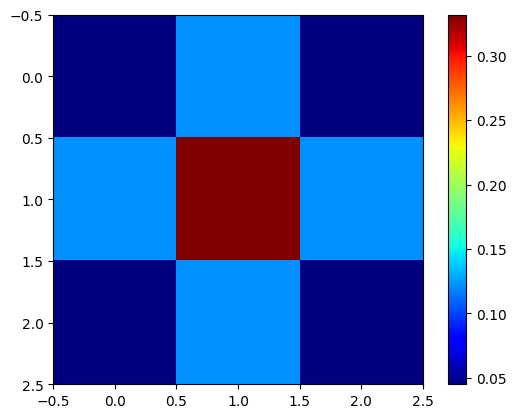

In [2]:
gaussian_kernel_array = gaussian_kernel(1)
print(gaussian_kernel_array)
plt.imshow(gaussian_kernel_array, cmap=plt.get_cmap('jet'), interpolation='nearest')
plt.colorbar()
plt.show()

When you add up the numbers above they will be equal to 1. That because when you convol an image with a kernel, you dont want to change the energy of the image.

# Denoising filters

In [3]:
from skimage import img_as_ubyte, img_as_float
from matplotlib import pyplot as plt
from skimage import io
import numpy as np


In [19]:
img = img_as_float(io.imread("/content/drive/MyDrive/denoising RGB/image1.jpg"))
#Need to convert to float as we will be doing math on the array, super important!!

#Original noisy image

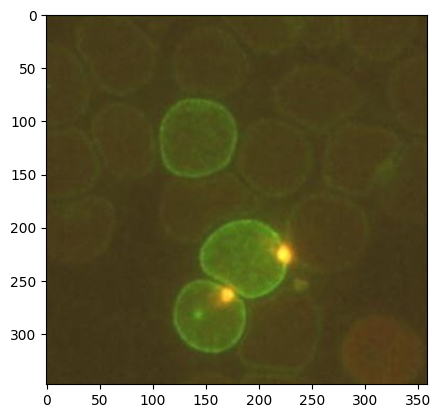

In [20]:
plt.imshow(img)

#Gaussian Filter

In [21]:
from scipy import ndimage as nd
gaussian_img = nd.gaussian_filter(img, sigma=3)
plt.imsave("/content/drive/MyDrive/denoising RGB/gaussian.jpg", gaussian_img)

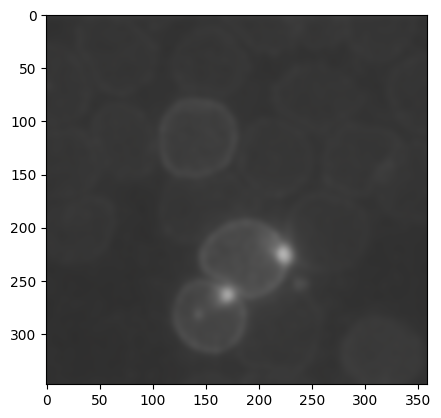

In [22]:
plt.imshow(gaussian_img)

Gaussian jpg looks pretty clean but image is very blurred. This is why Gaussian filtering is not used very often. Lets do median filtering.

#Median Filter

In [25]:
median_img = nd.median_filter(img, size=3)
plt.imsave("/content/drive/MyDrive/denoising RGB/median.jpg", median_img)

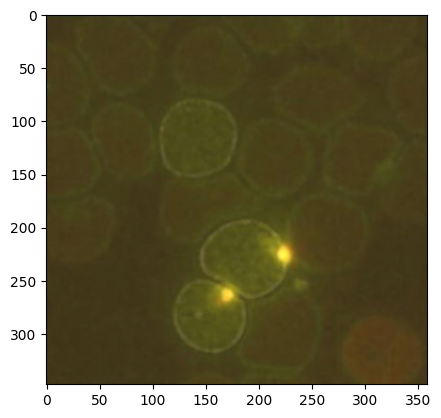

In [24]:
plt.imshow(median_img)

As you can see edges are perfectly preserved and image is denoised. Lets now look at non local means filter

# Non Local Means Filter

In [26]:
from skimage.restoration import denoise_nl_means, estimate_sigma
import numpy as np

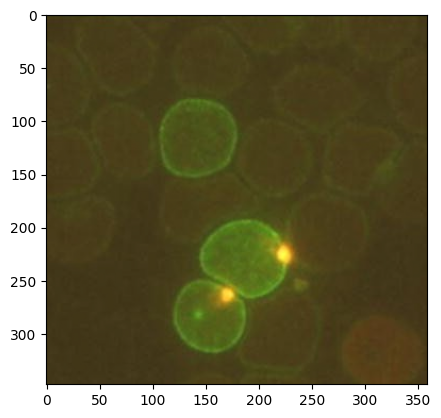

In [32]:
# Estimate noise
sigma_est = np.mean(estimate_sigma(img, channel_axis=-1))

# Parameters for NL-Means
patch_kw = dict(patch_size=5,
                patch_distance=3,
                channel_axis=-1)  # updated

# Denoise image
nlm = denoise_nl_means(img, h=0.1 * sigma_est, fast_mode=False,
                               **patch_kw)

### normally fast_mode=False, we sometimes use True, it saves a lot of time

# Convert to 8-bit if needed
nlm_8bit = img_as_ubyte(nlm)




# Save the image
plt.imsave("/content/drive/MyDrive/denoising RGB/NLM.jpg", nlm)
# Show the denoised image
plt.imshow(nlm)

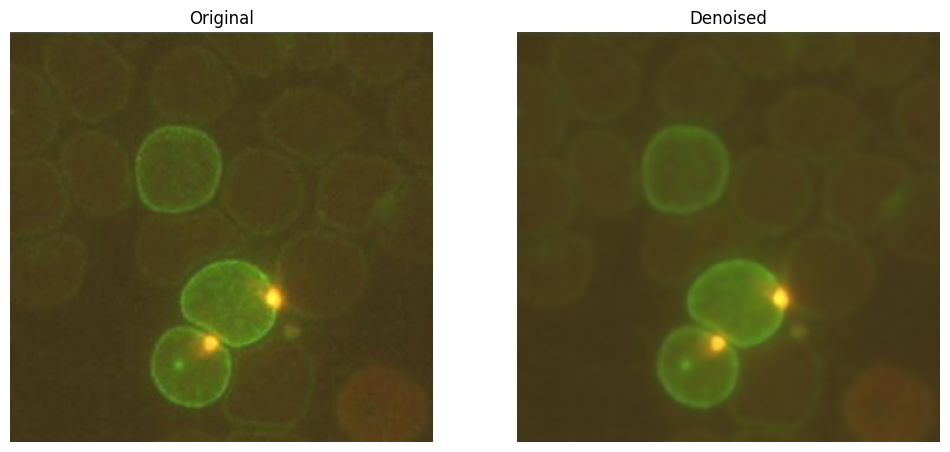

In [30]:
# Try stronger denoising
nlm = denoise_nl_means(img, h=0.1, fast_mode=False, **patch_kw)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(nlm)
plt.title("Denoised")
plt.axis("off")
plt.show()


# Why this worked better:
### 1. h controls filtering strength
  * In NL-means, h acts like a threshold for similarity between patches.
  * If h is too small (like 1.15 * sigma_est when sigma_est is tiny), the algorithm rejects almost all patches → almost no denoising.
  * When you set h=0.1, you gave the algorithm a larger tolerance → more averaging between similar patches → stronger noise reduction.

### 2. estimate_sigma underestimated the noise
  * Your image is probably a JPEG photo with weak Gaussian noise + compression artifacts.
  * estimate_sigma is designed for Gaussian white noise and often returns very small values in such cases.
  * So 1.15 * sigma_est was way too small to see an effect.

### 3. fast_mode=False improves quality
  * fast_mode=True uses fewer patch comparisons → faster but weaker denoising.
  * fast_mode=False checks more patches → better detail preservation + stronger smoothing, though slower.